# R Notebooks Setup - Facilitate easy on-boarding with R and SparkR notebooks.
-  SparkContext (sc) and SqlContext (sqlContext) are preconfigured
-  Default CRAN repository
-  Pre-installed packages
-  Connection to object store - read data, write intermediate or final results.

## Standard R code and plots
R is a language and environment for statistical computing and graphics. It provides a wide variety of statistical (linear and nonlinear modelling, classical statistical tests, time-series analysis, classification, clustering, …) and graphical techniques, and is highly extensible.

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa


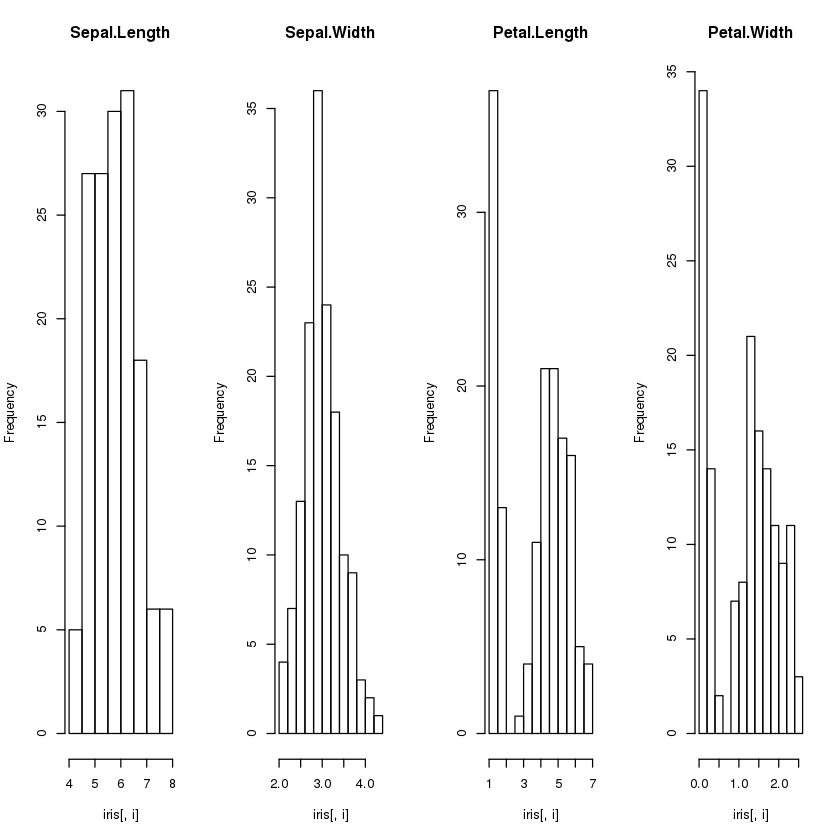

In [25]:
# load the data
data(iris)
head(iris)
# create histograms for each attribute
par(mfrow=c(1,4))
for(i in 1:4) {
hist(iris[,i], main=names(iris)[i])
}

### CRAN - The Comprehensive R Archive Network
CRAN is a network of ftp and web servers around the world that store identical, up-to-date, versions of code and documentation for R.

In [2]:
getOption("repos")

[1] "http://cran.cnr.berkeley.edu/"

### Pre-installed pacakges

In [3]:
#installed.packages()

## Scalable data analysis with SparkR (R on Spark)
SparkR is an R package that provides a light-weight frontend to use Apache Spark from R. In Spark 1.6.0, SparkR provides a distributed data frame implementation that supports operations like selection, filtering, aggregation etc. (similar to R data frames, dplyr) but on large datasets. SparkR also supports distributed machine learning using MLlib. A SparkR DataFrame is a distributed collection of data organized into named columns. It is conceptually equivalent to a table in a relational database or a data frame in R, but with richer optimizations under the hood. DataFrames can be constructed from a wide array of sources such as: structured data files, tables in Hive, external databases, or existing local R data frames.

### Preconfigured SparkContext and SqlContext

The entry point into SparkR is the SparkContext which connects your R program to a Spark cluster. You can create a SparkContext using sparkR.init and pass in options such as the application name , any spark packages depended on, etc. Further, to work with DataFrames we will need a SQLContext, which can be created from the SparkContext. 

In [4]:
sc
sqlContext

Java ref type org.apache.spark.api.java.JavaSparkContext id 0 

Java ref type org.apache.spark.sql.SQLContext id 1 

In [5]:
DF <- createDataFrame(sqlContext, iris)

Warning message in FUN(X[[i]], ...):
“Use Sepal_Length instead of Sepal.Length  as column name”Warning message in FUN(X[[i]], ...):
“Use Sepal_Width instead of Sepal.Width  as column name”Warning message in FUN(X[[i]], ...):
“Use Petal_Length instead of Petal.Length  as column name”Warning message in FUN(X[[i]], ...):
“Use Petal_Width instead of Petal.Width  as column name”

In [6]:
head(DF)

Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa


# A small simple sample ;) - Analyze flight delays

###  Directly create a SparkR DataFrame from the source data (csv file flights.csv in the associated Object Store)
For this example, we shall use the "flights" dataset. 
The dataset consists of every flight departing Houston in 2011.
The data set is made up of 227,496 rows x 14 columns.

In [7]:

# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
getObjectStorageFileWithCredentials_e5c4f52f5a8d4228b8539f78d2eac7ae <- function(container, filename) {
    # This functions returns a textConnection object for a file
    # from Bluemix Object Storage.

    if(!require(httr)) install.packages('httr')
    if(!require(RCurl)) install.packages('RCurl')
    library(httr, RCurl)
    auth_url <- paste("https://identity.open.softlayer.com",'/v3/auth/tokens', sep= '')
    auth_args <- paste('{"auth": {"identity": {"password": {"user": {"domain": {"id": ', "36aa3876656c40dbba129cb5068f2628",'},"password": ',
                    "Z&6398uWQzRPl.Ho",',"name": ', "member_fa58d6719f1339e10b41b92eac4dc6affcdb2c3a",'}},"methods": ["password"]}}}', sep='"')
    auth_response <- httr::POST(url = auth_url, body = auth_args)
    x_subject_token <-  headers(auth_response)[['x-subject-token']]
    auth_body <-  content(auth_response)
    access_url <-  unlist(lapply(auth_body[['token']][['catalog']], function(catalog){
        if((catalog[['type']] == 'object-store')){
            lapply(catalog[['endpoints']], function(endpoints){
                if(endpoints[['interface']] == 'public' && endpoints[['region_id']] == 'dallas') {
                    paste(endpoints[['url']], container, filename, sep='/')}
            })
        }
    }))
    data <- content(httr::GET(url = access_url, add_headers ("Content-Type" = "application/json", "X-Auth-Token" = x_subject_token)), as="text")
    textConnection(data)
}

df.data.1 <-  read.csv(file = getObjectStorageFileWithCredentials_e5c4f52f5a8d4228b8539f78d2eac7ae("ProdwithOS", "flights.csv"))
head(df.data.1)


Loading required package: httr
Loading required package: RCurl
Loading required package: bitops

Attaching package: ‘RCurl’

The following object is masked from ‘package:SparkR’:

    base64



X.html..h1.Not.Found..h1..p.The.resource.could.not.be.found...p...html.


In [8]:

# @hidden_cell
# This function is used to setup the access of Spark to your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
setHadoopConfigWithCredentials_e5c4f52f5a8d4228b8539f78d2eac7ae <- function(name) {
    # This function sets the Hadoop configuration so it is possible to
    # access data from Bluemix Object Storage using Spark

    prefix = paste("fs.swift.service" , name, sep =".")
    hConf = SparkR:::callJMethod(sc, "hadoopConfiguration")
    SparkR:::callJMethod(hConf, "set", paste(prefix, "auth.url", sep='.'), paste("https://identity.open.softlayer.com","/v3/auth/tokens",sep=""))
    SparkR:::callJMethod(hConf, "set", paste(prefix, "auth.endpoint.prefix", sep='.'), "endpoints")
    SparkR:::callJMethod(hConf, "set", paste(prefix, "tenant", sep='.'), "0f885dd557c94564820290f36199b2ac")
    SparkR:::callJMethod(hConf, "set", paste(prefix, "username", sep='.'), "4ad59159f9694a9780bf4dd98ba365b6")
    SparkR:::callJMethod(hConf, "set", paste(prefix, "password", sep='.'), "Z&6398uWQzRPl.Ho")
    SparkR:::callJMethod(hConf, "set", paste(prefix, "region", sep='.'), "dallas")
    invisible(SparkR:::callJMethod(hConf, "setBoolean", paste(prefix, "public", sep='.'), FALSE))
}

name <- "keystone"
setHadoopConfigWithCredentials_e5c4f52f5a8d4228b8539f78d2eac7ae(name)

flightsDF <- read.df(sqlContext, paste("swift://", "ProdwithOS", "." , name,"/", "flights.csv", sep=""), source = "com.databricks.spark.csv", header = "true")
head(flightsDF)


ERROR: Error in invokeJava(isStatic = TRUE, className, methodName, ...): org.apache.hadoop.mapred.InvalidInputException: Input path does not exist: swift://ProdwithOS.keystone/flights.csv
	at org.apache.hadoop.mapred.FileInputFormat.singleThreadedListStatus(FileInputFormat.java:285)
	at org.apache.hadoop.mapred.FileInputFormat.listStatus(FileInputFormat.java:228)
	at org.apache.hadoop.mapred.FileInputFormat.getSplits(FileInputFormat.java:313)
	at org.apache.spark.rdd.HadoopRDD.getPartitions(HadoopRDD.scala:199)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:239)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:237)
	at scala.Option.getOrElse(Option.scala:120)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:237)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:35)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:239)
	at org.apache.spark.rdd.RDD$$anonfun$partitions$2.apply(RDD.scala:237)
	at scala.Option.getOrElse(Option.scala:120)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:237)
	at org.apache.spark.rdd.RDD$$anonfun$take$1.apply(RDD.scala:1293)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.RDD.take(RDD.scala:1288)
	at com.databricks.spark.csv.CsvRelation.firstLine$lzycompute(CsvRelation.scala:249)
	at com.databricks.spark.csv.CsvRelation.firstLine(CsvRelation.scala:245)
	at com.databricks.spark.csv.CsvRelation.inferSchema(CsvRelation.scala:223)
	at com.databricks.spark.csv.CsvRelation.<init>(CsvRelation.scala:72)
	at com.databricks.spark.csv.DefaultSource.createRelation(DefaultSource.scala:157)
	at com.databricks.spark.csv.DefaultSource.createRelation(DefaultSource.scala:44)
	at org.apache.spark.sql.execution.datasources.ResolvedDataSource$.apply(ResolvedDataSource.scala:158)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:119)
	at org.apache.spark.sql.api.r.SQLUtils$.loadDF(SQLUtils.scala:160)
	at org.apache.spark.sql.api.r.SQLUtils.loadDF(SQLUtils.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:95)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:55)
	at java.lang.reflect.Method.invoke(Method.java:507)
	at org.apache.spark.api.r.RBackendHandler.handleMethodCall(RBackendHandler.scala:141)
	at org.apache.spark.api.r.RBackendHandler.channelRead0(RBackendHandler.scala:86)
	at org.apache.spark.api.r.RBackendHandler.channelRead0(RBackendHandler.scala:38)
	at io.netty.channel.SimpleChannelInboundHandler.channelRead(SimpleChannelInboundHandler.java:105)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:308)
	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:294)
	at io.netty.handler.codec.MessageToMessageDecoder.channelRead(MessageToMessageDecoder.java:103)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:308)
	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:294)
	at io.netty.handler.codec.ByteToMessageDecoder.channelRead(ByteToMessageDecoder.java:244)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelRead(AbstractChannelHandlerContext.java:308)
	at io.netty.channel.AbstractChannelHandlerContext.fireChannelRead(AbstractChannelHandlerContext.java:294)
	at io.netty.channel.DefaultChannelPipeline.fireChannelRead(DefaultChannelPipeline.java:846)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:131)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:511)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:468)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java:382)
	at io.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:354)
	at io.netty.util.concurrent.SingleThreadEventExecutor$2.run(SingleThreadEventExecutor.java:111)
	at io.netty.util.concurrent.DefaultThreadFactory$DefaultRunnableDecorator.run(DefaultThreadFactory.java:137)
	at java.lang.Thread.run(Thread.java:785)



### Print the first 6 rows of the DataFrame

In [9]:
head(flightsDF)

ERROR: Error in head(flightsDF): object 'flightsDF' not found


### Use SQL queries with the SparkR dataframe

In [10]:
# Using SQL to select columns of data
# First, register the flights DataFrame as a table
registerTempTable(flightsDF, "flightsTable")
destDF <- sql(sqlContext, "SELECT dest, cancelled FROM flightsTable where cancelled != 0")
head(destDF)

ERROR: Error in registerTempTable(flightsDF, "flightsTable"): object 'flightsDF' not found


### Filter as map reduce for SparkR

In [11]:
# Filter flights whose destination is JFK
jfkDF <- filter(flightsDF, flightsDF$dest == "JFK")
head(jfkDF)

ERROR: Error in filter(flightsDF, flightsDF$dest == "JFK"): object 'flightsDF' not found


### Calculate average delay per day

In [12]:
# If the magrittr library is available, we can use it to
# chain data frame operations
if("magrittr" %in% rownames(installed.packages())) {
  library(magrittr)

  # Group the flights by date and then find the average daily delay
  # Write the result into a DataFrame
  groupBy(flightsDF, flightsDF$date) %>%
    summarize(avg(flightsDF$dep_delay), avg(flightsDF$arr_delay)) -> dailyDelayDF

  # Print the computed data frame
  head(dailyDelayDF)
}

ERROR: Error in groupBy(flightsDF, flightsDF$date): object 'flightsDF' not found


### Calculate average delay per hour

In [13]:
# If the magrittr library is available, we can use it to chain data frame operations
if("magrittr" %in% rownames(installed.packages())) {
  library(magrittr)

  # Group the flights by hour and then find the average hourly delay. Write the result into a DataFrame
  groupBy(flightsDF, flightsDF$hour) %>%
    summarize(avg(flightsDF$dep_delay), avg(flightsDF$arr_delay)) -> hourlyDelayDF

  # Print the computed data frame
  head(hourlyDelayDF, n=12)
}

ERROR: Error in groupBy(flightsDF, flightsDF$hour): object 'flightsDF' not found


## Plot the results

### Install and load the desired packages

In [14]:
install.packages('ggplot2')
install.packages('tidyr')
library(ggplot2)
library(tidyr)

Installing package into ‘/gpfs/global_fs01/sym_shared/YPProdSpark/user/sb25-423d969da91c9c-90961e015575/R/libs’
(as ‘lib’ is unspecified)
Installing package into ‘/gpfs/global_fs01/sym_shared/YPProdSpark/user/sb25-423d969da91c9c-90961e015575/R/libs’
(as ‘lib’ is unspecified)

Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract

The following object is masked from ‘package:RCurl’:

    complete



### Shape the dataFrame for plotting

In [15]:
dailyDelay <- collect(dailyDelayDF)
names(dailyDelay)<- c('date','dep_delay', 'arr_delay')
dailyDelay$date <- as.Date(dailyDelay$date)
dailyDelay$date <- factor(dailyDelay$date)
dailyDelayLong <- gather(dailyDelay, delay_at, delay_time, dep_delay:arr_delay)

ERROR: Error in collect(dailyDelayDF): object 'dailyDelayDF' not found


In [16]:
hourlyDelay <- collect(hourlyDelayDF)
names(hourlyDelay)<- c('hour','dep_delay', 'arr_delay')
hourlyDelay$hour <- as.numeric(hourlyDelay$hour)
hourlyDelay$hour <- factor(hourlyDelay$hour)
hourlyDelayLong <- gather(hourlyDelay, delay_at, delay_time, dep_delay:arr_delay)

ERROR: Error in collect(hourlyDelayDF): object 'hourlyDelayDF' not found


In [17]:
ggplot(data=dailyDelayLong, aes(x=date, y=delay_time, group=delay_at, colour=delay_at)) +
    geom_line() +
    geom_point()

ERROR: Error in ggplot(data = dailyDelayLong, aes(x = date, y = delay_time, group = delay_at, : object 'dailyDelayLong' not found


In [18]:
ggplot(data=hourlyDelayLong, aes(x=hour, y=delay_time, group=delay_at, colour=delay_at)) +
    geom_line() +
    geom_point()

ERROR: Error in ggplot(data = hourlyDelayLong, aes(x = hour, y = delay_time, : object 'hourlyDelayLong' not found
